In [3]:
from odps import ODPS
from odps import options
import oss2
from odps.df import DataFrame
import datetime
import pandas as pd
import numpy as np
import threading
import queue

# connect信息
from ACCESS import ACCESS_ID
from ACCESS import SECRET_ACCESS_KEY
from ACCESS import ODPS_PROJECT
from ACCESS import ODPS_ENDPOINT
#FILE_PATH = ''

# # 此为外网地址
OSS_ENDPOINT = 'http://oss-cn-shanghai.aliyuncs.com'
OSS_BUCKET = 'hypertrons'

# oss实例
auth = oss2.Auth(ACCESS_ID, SECRET_ACCESS_KEY)
bucket = oss2.Bucket(auth, OSS_ENDPOINT, OSS_BUCKET)

# 创建odps实例
o = ODPS(ACCESS_ID, SECRET_ACCESS_KEY, project=ODPS_PROJECT, endpoint=ODPS_ENDPOINT)
options.tunnel.limit_instance_tunnel = False
# options.read_timeout = 3600000

TEMP_TABLE_NAME = 'TEMP_TABLE_NAME'

# 创建临时数据库
drop_sql = '''
DROP TABLE IF EXISTS {TEMP_TABLE_NAME};
CREATE TABLE IF NOT EXISTS {TEMP_TABLE_NAME}
(
    actor_login STRING,
    followers STRING
);
'''.format(
    TEMP_TABLE_NAME=TEMP_TABLE_NAME
)
o.execute_sql(drop_sql, hints={'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'})

<Instance 20220429044446540g0jne4pr2>

In [4]:
select_sql = '''
    set odps.sql.validate.orderby.limite=false;
    INSERT INTO {TEMP_TABLE_NAME}
    SELECT login, followers
    FROM ods_github_users
    '''.format(
        TEMP_TABLE_NAME=TEMP_TABLE_NAME
    )
table = o.execute_sql(select_sql, hints={'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'})

In [5]:
# 获取需要导出的项目
select_sql = '''
    set odps.sql.validate.orderby.limit=false;
    SELECT distinct actor_login, followers FROM {TEMP_TABLE_NAME}
    '''.format(
        TEMP_TABLE_NAME=TEMP_TABLE_NAME
    )
table = o.execute_sql(select_sql, hints={'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'})
print('获取数据成功')

获取数据成功


In [40]:
followers_num_list = []
with table.open_reader(tunnel=True) as reader:
    for record in reader:
        followers = record.followers
        if followers is None:
            followers_num_list.append(0)
        else:
            followers_num_list.append(followers.count(',') + 1)

In [72]:
followers_num_list.sort(reverse=True)
followers_sum = sum(followers_num_list)
followers_len = len(followers_num_list)

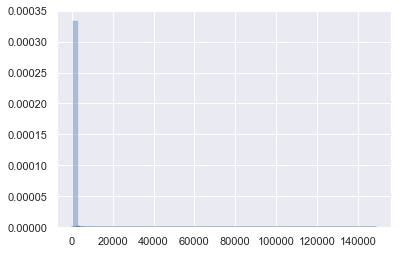

In [73]:
import seaborn as sns
sns.set()
sns.distplot(followers_num_list)

In [122]:
s = 0
for i in range(followers_len):
    s += followers_num_list[i]
    if s >= 0.5 * followers_sum:
        actor_percentage_1 = i / followers_len
        break
s = 0
for i in range(followers_len):
    s += followers_num_list[i]
    if s >= 0.8 * followers_sum:
        actor_percentage_2 = i / followers_len
        break

In [123]:
print(actor_percentage_1)
# 近前2%的人掌握了50%的粉丝总数
print(actor_percentage_2)
# 近前12%的人掌握了80%的粉丝总数

0.018350132550787508
0.12510809623045407


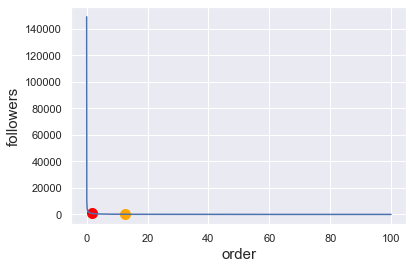

In [130]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0, 100, 100 / followers_len),followers_num_list)
plt.scatter(actor_percentage_1*100, followers_num_list[int(actor_percentage_1*followers_len)],c=['red'],s=[100])
plt.scatter(actor_percentage_2*100, followers_num_list[int(actor_percentage_2*followers_len)],c=['orange'],s=[100])
plt.xlabel('order', fontsize=15)
plt.ylabel('followers', fontsize=15)
plt.show()